### 주차수요 예측 AI 경진대회
#### 정형 | 한국토지주택공사 | 주차수요 | MAE

https://dacon.io/competitions/official/235745/overview/description

### 1) Import packages :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.ensemble import RandomForestRegressor

#### Hangul Font

In [3]:
plt.rc("font", family="Malgun Gothic")

### 2) Data loading :

In [4]:
train = pd.read_csv("train4.csv")
print(train.shape)
train.head(3)

(2952, 15)


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [5]:
test = pd.read_csv("test4.csv")
print(test.shape)
test.head(3)

(1022, 14)


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0


In [6]:
submission = pd.read_csv("sample_submission4.csv")
print(submission.shape)
submission.head(3)

(150, 2)


,code,num
0,C1072,0
1,C1128,0
2,C1456,0


In [7]:
age_gender = pd.read_csv("age_gender_info.csv")
age_gender.head(3)

,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),...,60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,...,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,...,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
2,대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,...,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066


### 3) Preprocessing :

#### 3-0) Data browsing

In [8]:
pd.pivot_table(data=train, 
               index=["단지코드","총세대수","임대건물구분","지역","공급유형", \
                      "전용면적","전용면적별세대수","공가수","자격유형","임대보증금","임대료"],
               values=["도보 10분거리 내 지하철역 수(환승노선 수 반영)","도보 10분거리 내 버스정류장 수", \
                       "단지내주차면수","등록차량수"]).head(10)

단지내주차면수  \
단지코드  총세대수 임대건물구분 지역   공급유형 전용면적  전용면적별세대수 공가수  자격유형 임대보증금    임대료               
C1000 566  아파트    충청북도 국민임대 39.57 26       10.0 A    10803000 96030     438.0   
                                  318      10.0 A    10803000 96030     438.0   
                            39.93 75       10.0 A    10803000 96030     438.0   
                            46.70 36       10.0 A    14404000 129640    438.0   
                            46.90 36       10.0 A    14404000 129640    438.0   
                            51.93 15       10.0 A    15604000 150040    438.0   
                                  60       10.0 A    15604000 150040    438.0   
C1004 521  아파트    충청남도 영구임대 39.30 240      3.0  C    4682000  104180    153.0   
                            39.69 264      3.0  C    4728000  105210    153.0   
C1005 1144 아파트    충청남도 국민임대 51.49 304      16.0 A    16205000 208470    950.0   

                                                                      도보 10분거리 내 버스정류장 수  \
단지코드  총세대수 임대건물구분 지역   공급유형 전용면적  전용면적별세대수 공가수  자격유형 임대보증금    임대료                          
C1000 566  아파트    충청북도 국민임대 39.57 26       10.0 A    10803000 96030                  1.0   
                                  318      10.0 A    10803000 96030                  1.0   
                            39.93 75       10.0 A    10803000 96030                  1.0   
                            46.70 36       10.0 A    14404000 129640                 1.0   
                            46.90 36       10.0 A    14404000 129640                 1.0   
                            51.93 15       10.0 A    15604000 150040                 1.0   
                                  60       10.0 A    15604000 150040                 1.0   
C1004 521  아파트    충청남도 영구임대 39.30 240      3.0  C    4682000  104180                 2.0   
                            39.69 264      3.0  C    4728000  105210                 2.0   
C1005 1144 아파트    충청남도 국민임대 51.49 304      16.0 A    16205000 208470                 8.0   

                                                                      도보 10분거리 내 지하철역 수(환승노선 수 반영)  \
단지코드  총세대수 임대건물구분 지역   공급유형 전용면적  전용면적별세대수 공가수  자격유형 임대보증금    임대료                                    
C1000 566  아파트    충청북도 국민임대 39.57 26       10.0 A    10803000 96030                            0.0   
                                  318      10.0 A    10803000 96030                            0.0   
                            39.93 75       10.0 A    10803000 96030                            0.0   
                            46.70 36       10.0 A    14404000 129640                           0.0   
                            46.90 36       10.0 A    14404000 129640                           0.0   
                            51.93 15       10.0 A    15604000 150040                           0.0   
                                  60       10.0 A    15604000 150040                           0.0   
C1004 521  아파트    충청남도 영구임대 39.30 240      3.0  C    4682000  104180                           NaN   
                            39.69 264      3.0  C    4728000  105210                           NaN   
C1005 1144 아파트    충청남도 국민임대 51.49 304      16.0 A    16205000 208470                           NaN   

                                                                      등록차량수  
단지코드  총세대수 임대건물구분 지역   공급유형 전용면적  전용면적별세대수 공가수  자격유형 임대보증금    임대료            
C1000 566  아파트    충청북도 국민임대 39.57 26       10.0 A    10803000 96030   481.0  
                                  318      10.0 A    10803000 96030   481.0  
                            39.93 75       10.0 A    10803000 96030   481.0  
                            46.70 36       10.0 A    14404000 129640  481.0  
                            46.90 36       10.0 A    14404000 129640  481.0  
                            51.93 15       10.0 A    15604000 150040  481.0  
                                  60       10.0 A    15604000 150040  481.0  
C1004 521  아파트    충청남도 영구임대 39.30 240      3.0  C    4682000  104

#### 3-0) Data error investiagtion

In [9]:
df_tr = pd.pivot_table(data=train, index=["단지코드","총세대수"], values="전용면적별세대수", aggfunc="sum").reset_index()
df_te = pd.pivot_table(data=test, index=["단지코드","총세대수"], values="전용면적별세대수", aggfunc="sum").reset_index()

In [10]:
t_1 = df_tr[(df_tr["총세대수"] - df_tr["전용면적별세대수"]) != 0]["단지코드"].unique()
t_2 = df_te[(df_te["총세대수"] - df_te["전용면적별세대수"]) != 0]["단지코드"].unique()
len(t_1) + len(t_2)

58

In [12]:
dup_code = pd.concat([pd.Series(t_1), pd.Series(t_2)], ignore_index=True)
len(dup_code)

58

In [13]:
# 주최측 Error 사항 반영:
# 1) Train: 삭제 - ['C2085','C1397','C2431','C1649','C1036','C1095','C2051','C1218','C1894','C2483','C1502','C1988']
# 2) Test: 평가제외 - ['C2675','C2335','C1327'] 

del_tr = ['C2085','C1397','C2431','C1649','C1036','C1095','C2051','C1218','C1894','C2483','C1502','C1988']; len(del_tr)

# 삭제실행:
print("삭제 전: ", train.shape)
for d in del_tr:
    train.drop(index=train[train["단지코드"] == d].index, inplace=True)    
print("삭제 후: ", train.shape)    

삭제 전:  (2952, 15)
삭제 후:  (2869, 15)


#### 3-1) Missing values

In [ ]:
train.info()
train.isnull().sum()

# 임대보증금                           569
# 임대료                             569
# 도보 10분거리 내 지하철역 수(환승노선 수 반영)    207

In [ ]:
test.info()
test.isnull().sum()

# 자격유형                              2
# 임대보증금                           180
# 임대료                             180
# 도보 10분거리 내 지하철역 수(환승노선 수 반영)     42

#### 3-2) Rename Columns:   지하철, 버스
  - 지하철: 도보 10분거리 내 지하철역 수(환승노선 수 반영)	
  - 버스  : 도보 10분거리 내 버스정류장 수
 

In [14]:
train.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)' : '지하철',
                     '도보 10분거리 내 버스정류장 수' : '버스' },
           inplace=True)

test.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)' : '지하철',
                     '도보 10분거리 내 버스정류장 수' : '버스' },
           inplace=True)

In [15]:
train.head(1)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
8,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000,82940,0.0,3.0,624.0,205.0


#### 3-3) Data encoding:

1) 임대건물구분	
  - 아파트: 0, 상가: 1  

In [16]:
train["임대건물구분"].unique()

train.loc[train["임대건물구분"] == "아파트", "임대구분(Encode)"] = 1
train.loc[train["임대건물구분"] == "상가", "임대구분(Encode)"] = 0

train["임대구분(Encode)"].value_counts()

1.0    2307
0.0     562
Name: 임대구분(Encode), dtype: int64

In [124]:
train[["임대건물구분","임대구분(Encode)"]].head(1)

,임대건물구분,임대구분(Encode)
8,아파트,1.0


In [91]:
test.loc[test["임대건물구분"] == "아파트", "임대구분(Encode)"] = 1
test.loc[test["임대건물구분"] == "상가", "임대구분(Encode)"] = 0

2) 지역
  - Encoding
  

In [126]:
# 지역 : One-hot encoding
pd.get_dummies(train["지역"]).head(1)

,강원도,경기도,경상남도,경상북도,광주광역시,대구광역시,대전광역시,부산광역시,서울특별시,세종특별자치시,울산광역시,전라남도,전라북도,제주특별자치도,충청남도,충청북도
8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
s_tr = pd.Series(train["지역"].unique(), index=train["지역"].unique(), name="train")
s_te = pd.Series(test["지역"].unique(), index=test["지역"].unique(), name="test")

s_tr = pd.Series(train["지역"].value_counts().index, index=train["지역"].value_counts().index, name="train")
s_te = pd.Series(test["지역"].value_counts().index, index=test["지역"].value_counts().index, name="test")

pd.concat([s_tr, s_te], axis=1)

,train,test
경기도,경기도,경기도
경상남도,경상남도,경상남도
부산광역시,부산광역시,부산광역시
대전광역시,대전광역시,대전광역시
강원도,강원도,강원도
충청북도,충청북도,충청북도
충청남도,충청남도,충청남도
전라남도,전라남도,전라남도
광주광역시,광주광역시,광주광역시
경상북도,경상북도,경상북도


3) 공급유형
  - Encoding  

In [17]:
train["공급유형"].value_counts().index

Index(['국민임대', '임대상가', '행복주택', '공공임대(10년)', '영구임대', '공공임대(50년)', '공공임대(분납)',
       '공공분양', '공공임대(5년)', '장기전세'],
      dtype='object')

In [18]:
s_tr = pd.Series(train["공급유형"].unique(), index=train["공급유형"].unique(), name="train")
s_te = pd.Series(test["공급유형"].unique(), index=test["공급유형"].unique(), name="test")

s_tr = pd.Series(train["공급유형"].value_counts().index, index=train["공급유형"].value_counts().index, name="train")
s_te = pd.Series(test["공급유형"].value_counts().index, index=test["공급유형"].value_counts().index, name="test")

pd.concat([s_tr, s_te], axis=1)

,train,test
국민임대,국민임대,국민임대
임대상가,임대상가,임대상가
행복주택,행복주택,행복주택
공공임대(10년),공공임대(10년),공공임대(10년)
영구임대,영구임대,영구임대
공공임대(50년),공공임대(50년),공공임대(50년)
공공임대(분납),공공임대(분납),공공임대(분납)
공공분양,공공분양,NaN
공공임대(5년),공공임대(5년),NaN
장기전세,장기전세,NaN


4) 전용면적 :
  - 평 단위로 전환 ( / 3.3)

In [21]:
train['전용면적(Encode)'] = round(train["전용면적"] / 3.3, ndigits=0)
train.head(1)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,임대구분(Encode),전용면적(Encode)
8,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000,82940,0.0,3.0,624.0,205.0,1.0,10.0


In [22]:
test['전용면적(Encode)'] = round(test["전용면적"] / 3.3, ndigits=0)
test.head(1)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,전용면적(Encode)
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0,12.0


5) 자격유형:


In [23]:
s_tr = pd.Series(train["자격유형"].value_counts().index, index=train["자격유형"].value_counts().index, name="train")
s_te = pd.Series(test["자격유형"].value_counts().index, index=test["자격유형"].value_counts().index, name="test")

pd.concat([s_tr, s_te], axis=1)

,train,test
A,A,A
D,D,D
H,H,H
J,J,J
C,C,C
I,I,I
E,E,E
L,L,L
K,K,K
N,N,N


In [132]:
# 지역 : 비교 검사

train["지역"].unique(), test["지역"].unique()

s_tr = pd.Series(train["지역"].unique(), index=train["지역"].unique(), name='train').sort_values()
s_te = pd.Series(test["지역"].unique(), index=test["지역"].unique(), name='test').sort_values()

pd.concat([s_tr,s_te], axis=1)

,train,test
강원도,강원도,강원도
경기도,경기도,경기도
경상남도,경상남도,경상남도
경상북도,경상북도,경상북도
광주광역시,광주광역시,광주광역시
대구광역시,대구광역시,대구광역시
대전광역시,대전광역시,대전광역시
부산광역시,부산광역시,부산광역시
서울특별시,서울특별시,NaN
세종특별자치시,세종특별자치시,세종특별자치시


### 4) Analysis :

In [133]:
train.head(1)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,임대구분(Encode),전용면적(Encode)
8,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000,82940,0.0,3.0,624.0,205.0,1.0,10.0


In [24]:
df_train = pd.pivot_table(data=train,
              index=['단지코드', '총세대수','지역'], # '공급유형','임대건물구분','자격유형'],
              values=['공가수','지하철', '버스', '단지내주차면수', '등록차량수', 
                      '전용면적(Encode)']).reset_index()    # '임대구분(Encode)'
df_train.head(5)

,단지코드,총세대수,지역,공가수,단지내주차면수,등록차량수,버스,전용면적(Encode),지하철
0,C1000,566,충청북도,10.0,438.0,481.0,1.0,13.714286,0.0
1,C1004,521,충청남도,3.0,153.0,93.0,2.0,11.842105,NaN
2,C1005,1144,충청남도,16.0,950.0,376.0,8.0,16.666667,NaN
3,C1013,1308,광주광역시,16.0,1119.0,1665.0,6.0,14.000000,0.0
4,C1014,996,전라북도,5.0,823.0,708.0,2.0,14.857143,0.0


#### 4-0) Correlation Analysis:

In [135]:
train.corr()[["단지내주차면수","등록차량수"]]

,단지내주차면수,등록차량수
총세대수,0.520272,0.326923
전용면적,0.060190,0.106366
전용면적별세대수,0.288788,0.254948
공가수,0.303954,0.130775
지하철,-0.047127,-0.101792
버스,0.078828,0.110977
단지내주차면수,1.000000,0.856549
등록차량수,0.856549,1.000000
임대구분(Encode),0.408928,0.449235
전용면적(Encode),0.057989,0.104691


In [136]:
df_train.corr()

,총세대수,공가수,단지내주차면수,등록차량수,버스,전용면적(Encode),지하철
총세대수,1.000000,0.297504,0.770985,0.594550,0.103052,0.005715,0.088989
공가수,0.297504,1.000000,0.395811,0.178797,0.061617,-0.196035,-0.119141
단지내주차면수,0.770985,0.395811,1.000000,0.847504,0.104887,0.153271,0.009567
등록차량수,0.594550,0.178797,0.847504,1.000000,0.116681,0.348566,-0.014299
버스,0.103052,0.061617,0.104887,0.116681,1.000000,0.038870,0.110461
전용면적(Encode),0.005715,-0.196035,0.153271,0.348566,0.038870,1.000000,-0.024384
지하철,0.088989,-0.119141,0.009567,-0.014299,0.110461,-0.024384,1.000000


#### 4-1) 총세대수:

<AxesSubplot:xlabel='총세대수', ylabel='단지내주차면수'>

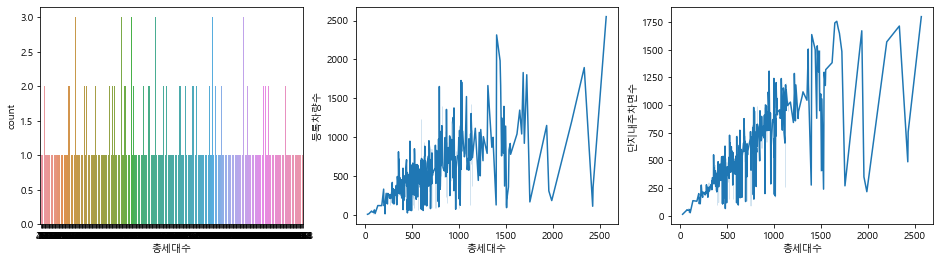

In [137]:
figure, (a1,a2,a3) = plt.subplots(nrows=1,ncols=3)
figure.set_size_inches(16,4)

sns.countplot(data=df_train, x="총세대수", ax=a1)
sns.lineplot(data=df_train, x="총세대수", y="등록차량수", ax=a2)
sns.lineplot(data=df_train, x="총세대수", y="단지내주차면수", ax=a3)

[(-200.0, 2700.0)]

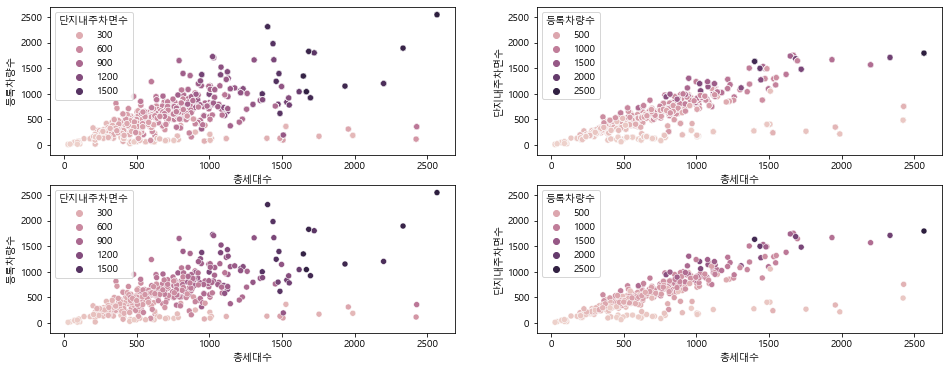

In [138]:
figure, ((a1,a2),(a3,a4)) = plt.subplots(nrows=2,ncols=2)
figure.set_size_inches(16,6)

sns.scatterplot(data=train, x="총세대수", y="등록차량수", hue="단지내주차면수", ax=a1).set(ylim=(-200,2700))
sns.scatterplot(data=train, x="총세대수", y="단지내주차면수", hue="등록차량수", ax=a2).set(ylim=(-200,2700))
sns.scatterplot(data=df_train, x="총세대수", y="등록차량수", hue="단지내주차면수", ax=a3).set(ylim=(-200,2700))
sns.scatterplot(data=df_train, x="총세대수", y="단지내주차면수", hue="등록차량수", ax=a4).set(ylim=(-200,2700))

단지내주차면수 vs. 등록차량수 : slope = 0.172, intercept = 3.671


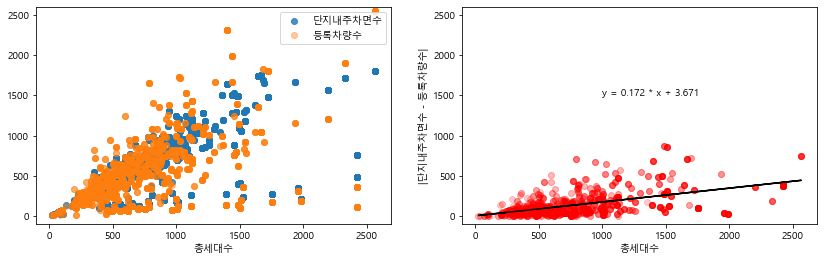

In [139]:
figure, ax = plt.subplots(1,2)

figure.set_size_inches(14,4)

ax[0].set_xlabel("총세대수")
ax[0].set_ylim(-100,2600)
ax[0].scatter(x=train["총세대수"], y=train["단지내주차면수"], label="단지내주차면수", alpha=0.8)
ax[0].scatter(x=train["총세대수"], y=train["등록차량수"], label="등록차량수", alpha=0.4)
ax[0].legend()

ax[1].set_xlabel("총세대수")
ax[1].set_ylabel("|단지내주차면수 - 등록차량수|")
ax[1].set_ylim(-100,2600)
ax[1].scatter(x=train["총세대수"], y=np.abs(train["단지내주차면수"] - train["등록차량수"]), color='red', alpha=0.1)


# abline #
t_x = train["총세대수"].values
t_y = np.abs(train["단지내주차면수"] - train["등록차량수"]).values
a, b = np.polyfit(t_x, t_y, 1)
abline = [a * i + b for i in t_x]
ax[1].plot(t_x, abline, color='k')
ax[1].text(1000,1500,f"y = {a:.3f} * x + {b:.3f}")
print(f"단지내주차면수 vs. 등록차량수 : slope = {a:.3f}, intercept = {b:.3f}")

plt.show()

#### 4-2) 임대건물구분:

In [25]:
df_train = pd.pivot_table(data=train,
              index=['단지코드', '총세대수','지역','임대건물구분'], # '공급유형','자격유형'],
              values=['공가수','지하철', '버스', '단지내주차면수', '등록차량수', 
                      '전용면적(Encode)','임대구분(Encode)']).reset_index()  
df_train.head(5)

,단지코드,총세대수,지역,임대건물구분,공가수,단지내주차면수,등록차량수,버스,임대구분(Encode),전용면적(Encode),지하철
0,C1000,566,충청북도,아파트,10.0,438.0,481.0,1.0,1.0,13.714286,0.0
1,C1004,521,충청남도,상가,3.0,153.0,93.0,2.0,0.0,11.823529,NaN
2,C1004,521,충청남도,아파트,3.0,153.0,93.0,2.0,1.0,12.000000,NaN
3,C1005,1144,충청남도,아파트,16.0,950.0,376.0,8.0,1.0,16.666667,NaN
4,C1013,1308,광주광역시,아파트,16.0,1119.0,1665.0,6.0,1.0,14.000000,0.0


[(-100.0, 2600.0)]

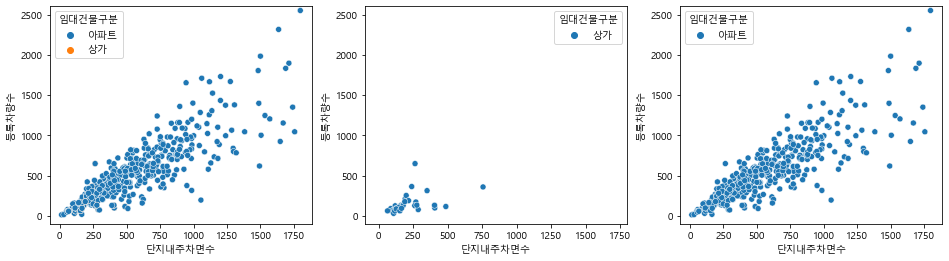

In [26]:
figure, (a1,a2,a3) = plt.subplots(nrows=1,ncols=3)
figure.set_size_inches(16,4)

sns.scatterplot(data=df_train, x="단지내주차면수", y="등록차량수", hue="임대건물구분", ax=a1).set(ylim=(-100,2600))
sns.scatterplot(data=df_train.loc[df_train["임대건물구분"] == "상가", ["임대건물구분","단지내주차면수","등록차량수"]],
                x="단지내주차면수", y="등록차량수", hue="임대건물구분", ax=a2).set(ylim=(-100,2600),xlim=(-100,1800))
sns.scatterplot(data=df_train.loc[df_train["임대건물구분"] == "아파트", ["임대건물구분","단지내주차면수","등록차량수"]],
                x="단지내주차면수", y="등록차량수", hue="임대건물구분", ax=a3).set(ylim=(-100,2600))

#### 4-3) 지역:

In [142]:
train.head(1)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,임대구분(Encode),전용면적(Encode)
8,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000,82940,0.0,3.0,624.0,205.0,1.0,10.0


#### Case : 4-3-1) 지역별 차량등록 평균 기준:

In [37]:
df_train1 = pd.pivot_table(data=train,
                          index=['지역','단지코드'],
                          values=['단지내주차면수', '등록차량수']).reset_index() 
df_train1
df_train2 = pd.pivot_table(data=df_train1,
                          index="지역", values=['단지코드','단지내주차면수','등록차량수'],
                          aggfunc={'단지코드' : 'count',
                                   '단지내주차면수' : 'mean',
                                   '등록차량수' : [min, 'mean', max, 'median']}).reset_index()
df_train2.columns = ['지역','단지내주차면수mean','단지count','등록차량max','등록차량mean','등록차량median','등록차량min']

t_col = ["지역","단지count","단지내주차면수mean","등록차량mean","등록차량max","등록차량median","등록차량min"]
df_train2[t_col].head()

,지역,단지count,단지내주차면수mean,등록차량mean,등록차량max,등록차량median,등록차량min
0,강원도,37,364.540541,385.081081,1084.0,305.0,19.0
1,경기도,84,723.488095,721.523810,2550.0,654.5,13.0
2,경상남도,53,521.547170,470.452830,1359.0,479.0,31.0
3,경상북도,21,556.523810,595.761905,1255.0,521.0,163.0
4,광주광역시,24,623.958333,713.041667,1730.0,701.5,59.0


In [38]:
df_train2[t_col].describe()

,단지count,단지내주차면수mean,등록차량mean,등록차량max,등록차량median,등록차량min
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,25.687500,607.881536,608.117658,1425.062500,559.343750,177.062500
std,19.723822,255.248334,342.660961,545.141751,366.018611,371.760042
min,3.000000,332.842105,288.526316,609.000000,253.000000,13.000000
25%,17.000000,472.488095,449.109893,1063.250000,392.500000,21.250000
50%,22.500000,576.428571,521.850000,1366.500000,461.500000,58.000000
75%,26.250000,652.305000,663.540417,1714.250000,596.375000,133.000000
max,84.000000,1443.666667,1779.666667,2550.000000,1832.000000,1524.000000


등록차량mean :

>- A :  < 450
>- B :  450 <=    < 522
>- C :  522 <=    < 664
>- D :  664 >

In [46]:
df_train2.loc[df_train2["등록차량mean"] < 450, "지역"].unique()
# -> ['강원도', '울산광역시', '제주특별자치도', '충청남도']
df_train2.loc[(df_train2["등록차량mean"] >= 450) & (df_train2["등록차량mean"] < 552), "지역"].unique()
# -> ['경상남도', '부산광역시', '전라남도', '전라북도']
df_train2.loc[(df_train2["등록차량mean"] >= 552) & (df_train2["등록차량mean"] < 664), "지역"].unique()
# -> ['경상북도', '대전광역시', '서울특별시', '충청북도']
df_train2.loc[df_train2["등록차량mean"] > 664, "지역"].unique()
# -> ['경기도', '광주광역시', '대구광역시', '세종특별자치시']

array(['경상북도', '대전광역시', '서울특별시', '충청북도'], dtype=object)

In [47]:
train.loc[(train["지역"] == "강원도") | (train["지역"] == "울산광역시") | (train["지역"] == "제주특별자치도") | (train["지역"] == "충청남도"), "지역(Encode)"] = 'A'
train.loc[(train["지역"] == "경상남도") | (train["지역"] == "부산광역시") | (train["지역"] == "전라남도") | (train["지역"] == "전라북도"), "지역(Encode)"] = 'B'
train.loc[(train["지역"] == "경상북도") | (train["지역"] == "대전광역시") | (train["지역"] == "서울특별시") | (train["지역"] == "충청북도"), "지역(Encode)"] = 'C'
train.loc[(train["지역"] == "경기도") | (train["지역"] == "광주광역시") | (train["지역"] == "대구광역시") | (train["지역"] == "세종특별자치시"), "지역(Encode)"] = 'D'

In [48]:
# 지역 : One-hot encoding
pd.get_dummies(train["지역(Encode)"]).head(3)
print(train.shape)
train = pd.concat([train,pd.get_dummies(train["지역(Encode)"])],axis=1)
print(train.shape)
train.head(1)

(2869, 18)
(2869, 22)


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,버스,단지내주차면수,등록차량수,임대구분(Encode),전용면적(Encode),지역(Encode),A,B,C,D
8,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000,...,3.0,624.0,205.0,1.0,10.0,B,0,1,0,0


In [49]:
## Test dataset:
test.loc[(test["지역"] == "강원도") | (test["지역"] == "울산광역시") | (test["지역"] == "제주특별자치도") | (test["지역"] == "충청남도"), "지역(Encode)"] = 'A'
test.loc[(test["지역"] == "경상남도") | (test["지역"] == "부산광역시") | (test["지역"] == "전라남도") | (test["지역"] == "전라북도"), "지역(Encode)"] = 'B'
test.loc[(test["지역"] == "경상북도") | (test["지역"] == "대전광역시") | (test["지역"] == "서울특별시") | (test["지역"] == "충청북도"), "지역(Encode)"] = 'C'
test.loc[(test["지역"] == "경기도") | (test["지역"] == "광주광역시") | (test["지역"] == "대구광역시") | (test["지역"] == "세종특별자치시"), "지역(Encode)"] = 'D'

In [50]:
# 지역 : One-hot encoding
pd.get_dummies(test["지역(Encode)"]).head(3)
print(test.shape)
test = pd.concat([test,pd.get_dummies(test["지역(Encode)"])],axis=1)
print(test.shape)
test.head(1)

(1022, 16)
(1022, 20)


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,전용면적(Encode),지역(Encode),A,B,C,D
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0,12.0,D,0,0,0,1


#### Case : 4-3-2) |단지내주차면수(평균) - 등록차량수(평균)| 차이값 기준:

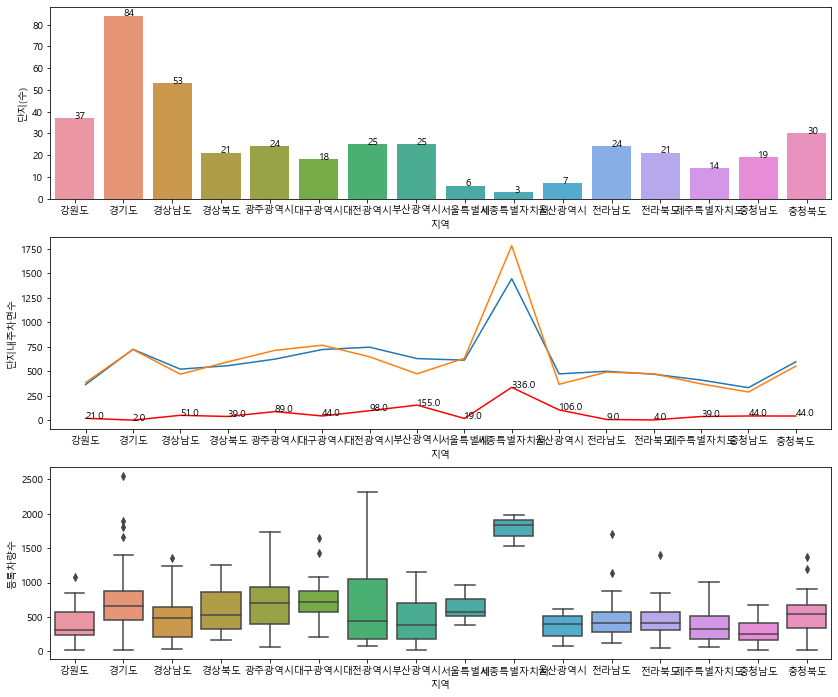

In [28]:
df_train1 = pd.pivot_table(data=train,
                          index=['지역','단지코드'],
                          values=['단지내주차면수', '등록차량수']).reset_index() 
df_train1
df_train2 = pd.pivot_table(data=df_train1,
                          index="지역", values=['단지코드','단지내주차면수','등록차량수'],
                          aggfunc={'단지코드' : 'count',
                                   '단지내주차면수' : 'mean',
                                   '등록차량수' : 'mean'}).reset_index()
df_train2

figure, (a1,a2,a3) = plt.subplots(nrows=3,ncols=1)
figure.set_size_inches(14,12)

# 1. 지역  -  단지(수)
sns.barplot(data=df_train2, x="지역", y="단지코드", ax=a1).set_ylabel("단지(수)")
# 2. 지역  - 주차면수 & 등록차량수 & 차이(diff)
sns.lineplot(data=df_train2, x="지역", y="단지내주차면수", ax=a2)
sns.lineplot(data=df_train2, x="지역", y="등록차량수", ax=a2)
sns.lineplot(data=df_train2, x="지역", y=np.abs(df_train2["등록차량수"] - df_train2["단지내주차면수"]), ax=a2, color='r')
# 3. 지역  - 등록차량수 분포(기술통계값)
sns.boxplot(data=df_train1, x="지역", y="등록차량수", ax=a3)

## Text
for p in range(0, len(df_train2)):
    a1.text(df_train2.index[p], df_train2.iloc[p,2], df_train2.iloc[p,2])
    a2.text(df_train2.index[p], np.abs(df_train2.iloc[p,3] - df_train2.iloc[p,1]), 
            round(np.abs(df_train2.iloc[p,3] - df_train2.iloc[p,1]),0))

plt.show()    

##### `|단지내주차면수(평균) - 등록차량수(평균)| 차이값 기준으로 지역 구분`:
- 0 : 01-20 -> 강원도,경기도,서울특별시,전라남도,전라북도
- 1 : 21-50 -> 경상남도,경상북도,대구광역시,제주특별자치도,충청남도,충청북도
- 2 : 51-90 -> 광주광역시,대전광역시,울산광역시
- 3 : 155   -> 부산광역시
- 4 : 336   -> 세종특별자치시

In [144]:
train.loc[(train["지역"] == "강원도") | (train["지역"] == "경기도") | (train["지역"] == "서울특별시") | (train["지역"] == "전라남도") | (train["지역"] == "전라북도"), "지역(Encode)"] = 'A'
train.loc[(train["지역"] == "경상남도") | (train["지역"] == "경상북도") | (train["지역"] == "대구광역시") | (train["지역"] == "제주특별자치도") | (train["지역"] == "충청남도") | (train["지역"] == "충청북도"), "지역(Encode)"] = 'B'
train.loc[(train["지역"] == "광주광역시") | (train["지역"] == "대전광역시") | (train["지역"] == "울산광역시"), "지역(Encode)"] = 'C'
train.loc[(train["지역"] == "부산광역시"), "지역(Encode)"] = 'D'
train.loc[(train["지역"] == "세종특별자치시"), "지역(Encode)"] = 'E'

In [145]:
train.head(1)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,임대구분(Encode),전용면적(Encode),지역(Encode)
8,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000,82940,0.0,3.0,624.0,205.0,1.0,10.0,B


In [146]:
# 지역 : One-hot encoding
pd.get_dummies(train["지역(Encode)"]).head(3)
print(train.shape)
train = pd.concat([train,pd.get_dummies(train["지역(Encode)"])],axis=1)
print(train.shape)
train.head(1)

(2869, 18)
(2869, 23)


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,단지내주차면수,등록차량수,임대구분(Encode),전용면적(Encode),지역(Encode),A,B,C,D,E
8,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000,...,624.0,205.0,1.0,10.0,B,0,1,0,0,0


In [147]:
test.loc[(test["지역"] == "강원도") | (test["지역"] == "경기도") | (test["지역"] == "서울특별시") | (test["지역"] == "전라남도") | (test["지역"] == "전라북도"), "지역(Encode)"] = 'A'
test.loc[(test["지역"] == "경상남도") | (test["지역"] == "경상북도") | (test["지역"] == "대구광역시") | (test["지역"] == "제주특별자치도") | (test["지역"] == "충청남도") | (test["지역"] == "충청북도"), "지역(Encode)"] = 'B'
test.loc[(test["지역"] == "광주광역시") | (test["지역"] == "대전광역시") | (test["지역"] == "울산광역시"), "지역(Encode)"] = 'C'
test.loc[(test["지역"] == "부산광역시"), "지역(Encode)"] = 'D'
test.loc[(test["지역"] == "세종특별자치시"), "지역(Encode)"] = 'E'

In [148]:
# 지역 : One-hot encoding
pd.get_dummies(test["지역(Encode)"]).head(3)
print(test.shape)
test = pd.concat([test,pd.get_dummies(test["지역(Encode)"])],axis=1)
print(test.shape)
test.head(1)

(1022, 17)
(1022, 22)


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,버스,단지내주차면수,임대구분(Encode),전용면적(Encode),지역(Encode),A,B,C,D,E
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,...,2.0,683.0,1.0,12.0,A,1,0,0,0,0


#### 4-4) 공가수:

In [51]:
train.head(1)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,버스,단지내주차면수,등록차량수,임대구분(Encode),전용면적(Encode),지역(Encode),A,B,C,D
8,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000,...,3.0,624.0,205.0,1.0,10.0,B,0,1,0,0


In [52]:
df_t = pd.pivot_table(data=train, index="공가수", values=["단지내주차면수","등록차량수"])
df_t.head(1)

,단지내주차면수,등록차량수
공가수,,
0.0,320.860215,325.064516


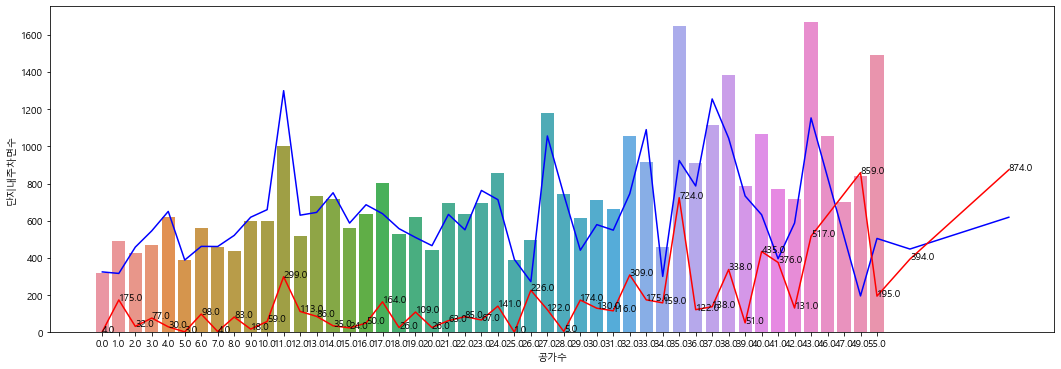

In [53]:
plt.figure(figsize=(18,6))

sns.barplot(data=df_t, x=df_t.index, y="단지내주차면수")
sns.lineplot(data=df_t, x=df_t.index, y="등록차량수", color='b')
sns.lineplot(x=df_t.index, y=np.abs(df_t["등록차량수"] - df_t["단지내주차면수"]), color='r')

## Text
for p in range(0, len(df_t)):
    plt.text(df_t.index[p], np.abs(df_t.iloc[p,1] - df_t.iloc[p,0]), 
            round(np.abs(df_t.iloc[p,1] - df_t.iloc[p,0]),0))

plt.show()    

#### 4-5) 전용면적(Encode), 전용면적별세대수:

In [54]:
train.head(1)
train["면적(Encode)*면적별세대"] = train["전용면적(Encode)"] * train["전용면적별세대수"]

In [55]:
t_col = ["단지코드","전용면적","전용면적(Encode)","전용면적별세대수","단지내주차면수","등록차량수","면적(Encode)*면적별세대"]
train[t_col].head(5)
# train.loc[train["단지코드"]=="C1000", ["단지내주차면수","등록차량수","면적(Encode)*면적별세대"]]

,단지코드,전용면적,전용면적(Encode),전용면적별세대수,단지내주차면수,등록차량수,면적(Encode)*면적별세대
8,C2515,33.48,10.0,276,624.0,205.0,2760.0
9,C2515,39.60,12.0,60,624.0,205.0,720.0
10,C2515,39.60,12.0,20,624.0,205.0,240.0
11,C2515,46.90,14.0,38,624.0,205.0,532.0
12,C2515,46.90,14.0,19,624.0,205.0,266.0


In [56]:
test["면적(Encode)*면적별세대"] = test["전용면적(Encode)"] * test["전용면적별세대수"]

In [60]:
df_t.head(1)

,단지내주차면수,등록차량수,면적(Encode)*면적별세대
단지코드,,,
C1000,438.0,481.0,7236.0


In [58]:
df_t = pd.pivot_table(data=train, index="단지코드", 
               values=["면적(Encode)*면적별세대","단지내주차면수","등록차량수"],
               aggfunc = {"면적(Encode)*면적별세대" : 'sum',
                          "단지내주차면수" : 'mean',
                          "등록차량수" : 'mean'})

## 제거 : 총세대수 !=  SUM(세대수)
print(df_t.shape, len(dup_code))

for d in dup_code:
    df_t.drop(index=df_t[df_t.index == d].index, inplace=True)
    
print(df_t.shape)

(411, 3) 58
(373, 3)


In [65]:
## For test dataset:
df_t2 = pd.pivot_table(data=test, index="단지코드", 
               values=["면적(Encode)*면적별세대","단지내주차면수"],
               aggfunc = {"면적(Encode)*면적별세대" : 'sum',
                          "단지내주차면수" : 'mean'})
df_t2.head(3)

,단지내주차면수,면적(Encode)*면적별세대
단지코드,,
C1003,339.0,3830.0
C1006,428.0,12662.0
C1016,646.0,9592.0


<AxesSubplot:xlabel='면적(Encode)*면적별세대', ylabel='단지내주차면수'>

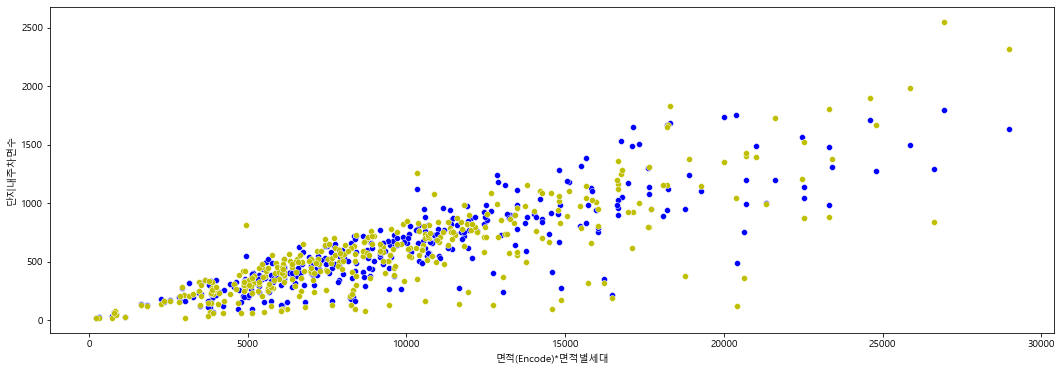

In [59]:
df_t.head(1)

plt.figure(figsize=(18,6))

sns.scatterplot(data=df_t, x="면적(Encode)*면적별세대", y="단지내주차면수", color='b')
sns.scatterplot(data=df_t, x="면적(Encode)*면적별세대", y="등록차량수", color='y')

#### 4-6) Train, Test 보정작업:

In [66]:
train.head(1)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,단지내주차면수,등록차량수,임대구분(Encode),전용면적(Encode),지역(Encode),A,B,C,D,면적(Encode)*면적별세대
8,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000,...,624.0,205.0,1.0,10.0,B,0,1,0,0,2760.0


In [67]:
df_t.head(1)

,단지내주차면수,등록차량수,면적(Encode)*면적별세대
단지코드,,,
C1000,438.0,481.0,7236.0


In [81]:
for x in dup_code:
    train.loc[train["단지코드"] == x, "면적*세대"] = 0

In [82]:
for c in range(0, len(df_t)):
    t_code = df_t.index[c]
    t_area = df_t.loc[df_t.index[c], "면적(Encode)*면적별세대"]
    train.loc[train["단지코드"] == t_code, "면적*세대"] = t_area


In [83]:
train["면적*세대"].isnull().sum()

0

In [84]:
## For test dataset:

for c in range(0, len(df_t2)):
    t_code = df_t2.index[c]
    t_area = df_t2.loc[df_t2.index[c], "면적(Encode)*면적별세대"]
    test.loc[test["단지코드"] == t_code, "면적*세대"] = t_area


In [85]:
test["면적*세대"].isnull().sum()

0

In [86]:
train.head(1)
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철', '버스', '단지내주차면수', '등록차량수', '임대구분(Encode)',
       '전용면적(Encode)', '지역(Encode)', 'A', 'B', 'C', 'D', '면적(Encode)*면적별세대',
       '면적*세대'],
      dtype='object')

In [87]:
train.corr()["등록차량수"]  

총세대수                0.326923
전용면적                0.106366
전용면적별세대수            0.254948
공가수                 0.130775
지하철                -0.101792
버스                  0.110977
단지내주차면수             0.856549
등록차량수               1.000000
임대구분(Encode)        0.449235
전용면적(Encode)        0.104691
A                  -0.232787
B                  -0.242695
C                   0.023876
D                   0.415815
면적(Encode)*면적별세대    0.343604
면적*세대               0.638878
Name: 등록차량수, dtype: float64

### 5) Modeling :

#### 5-1) Feature & Target

In [88]:
f_names = ["총세대수","단지내주차면수","임대구분(Encode)","A","B","C","D","공가수","면적*세대"]

In [89]:
X_train = train[f_names]
y_train = train["등록차량수"]

In [92]:
X_test = test[f_names]

#### 5-2) Fit & Predict

In [101]:
rf_reg = RandomForestRegressor(n_estimators=300, criterion='mae', random_state=41)

In [93]:
# Tuning :

rf_reg = RandomForestRegressor(max_depth=60, min_samples_leaf=30, 
                               min_samples_split=30, n_estimators=230)

In [94]:
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=60, min_samples_leaf=30, min_samples_split=30,
                      n_estimators=230)

In [95]:
pred = rf_reg.predict(X_test)
len(pred)

1022

#### 5-3) Evaluation

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

##### Case 1) Hold-out validation

In [105]:
X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(X_train, y_train, 
                                                                        shuffle=False, test_size=0.1, random_state=41)

In [106]:
rf_reg.fit(X_train_eval, y_train_eval)

RandomForestRegressor(criterion='mae', n_estimators=300, random_state=41)

In [107]:
pred_eval = rf_reg.predict(X_test_eval)

In [108]:
mean_absolute_error(pred_eval, y_test_eval)

171.01709639953543

##### Case 2) Cross validation

In [109]:
score_mae = cross_val_score(rf_reg, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
np.mean(score_mae)

-176.98758722760377

In [110]:
## Features importance : 

pd.DataFrame(rf_reg.feature_importances_, index=X_train.columns, columns=["f_importance"]).sort_values(by="f_importance", ascending=False)

,f_importance
단지내주차면수,0.673874
총세대수,0.220538
임대구분(Encode),0.057474
전용면적(Encode),0.048114


#### 5-4) Tuning

In [70]:
from sklearn.model_selection import GridSearchCV

In [71]:
rf_reg = RandomForestRegressor()

In [72]:
parameters = {
    "max_depth" : [45,50,60,80],
    "n_estimators" : [180,200,230,250],
    "min_samples_split" : [25,30,35],
    "min_samples_leaf" : [25,30,35],
}

grid_rf = GridSearchCV(rf_reg, param_grid=parameters, cv=5, scoring="neg_mean_absolute_error", verbose=1, n_jobs=-1)

In [73]:
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [45, 50, 60, 80],
                         'min_samples_leaf': [25, 30, 35],
                         'min_samples_split': [25, 30, 35],
                         'n_estimators': [180, 200, 230, 250]},
             scoring='neg_mean_absolute_error', verbose=1)

In [74]:
print(grid_rf.best_score_)
print(grid_rf.best_params_)
print(grid_rf.best_estimator_)

-159.28545923737494
{'max_depth': 60, 'min_samples_leaf': 30, 'min_samples_split': 30, 'n_estimators': 230}
RandomForestRegressor(max_depth=60, min_samples_leaf=30, min_samples_split=30,
                      n_estimators=230)


### 6) Submission

In [96]:
print(test.shape, len(pred), submission.shape)

(1022, 23) 1022 (150, 2)


#### 제출용 파일 재구성 작업:

In [97]:
test["pred"] = pred

In [98]:
test.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,전용면적(Encode),지역(Encode),A,B,C,D,면적(Encode)*면적별세대,면적*세대,임대구분(Encode),pred
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,...,12.0,D,0,0,0,1,1392.0,11076.0,1.0,779.479252
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,...,14.0,D,0,0,0,1,420.0,11076.0,1.0,779.479252
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,...,14.0,D,0,0,0,1,1568.0,11076.0,1.0,779.479252


In [99]:
submission.head(2)

,code,num
0,C1072,0
1,C1128,0


In [100]:
test.loc[test["단지코드"] == "C1072", "pred"].values[0]
test.loc[test["단지코드"] == "C1072", "pred"].head(1).iloc[0]

for s in range(0, len(submission)):
    code = submission.loc[s,"code"]
    submission.loc[s,"num"] = test.loc[test["단지코드"] == code, "pred"].values[0]

print(submission.shape)    
submission.head(3)    

(150, 2)


,code,num
0,C1072,779.479252
1,C1128,1486.755359
2,C1456,537.712610


In [101]:
submission.to_csv("dacon-211015_1450.csv", index=False)